#### AMPEL intro

AMPEL is software framework designed for processing heterogeneous streamed data. 

AMPEL was not developed to provide a specific scientific resource, but rather an environment where it is easy to ensure that a scientific program fulfills the strict requirement of the next generation real-time experiments: efficient and powerful analysis, where provenance and reproducibiltiy is paramount. In particular, to guarantee the last point requires algorithms (which make real-time deicsions) be separated from infrastructure (which will likely evolve with time and project phase).

An AMPEL _user_ constructs a configuration file which describes every step of how an incoming alert stream should be processed. This can be broken down into selecting which _units_ should be executed, and which _parameters_ each of these should be provided. An AMPEL _live instance_ executes these units, based on the input data, as requested and stores all intermediate and final data in a databse. 

Provenance/reproducibility is ensured through multiple layers. First, each live instance is run from a container which can be retrieved later and together with a data archive replay the full stream. Second, AMPEL contains an extensive set of logs and a transient-specific _Journal_ which details all related actions/decisions. Finally, each unit and channel configuration file is drawn from a specific (tagged) github version. 

The series of notebooks provided here gradually builds toward a sample full configration. 


#### Sample science case

Each AMPEl _channel_ is designed with a science goal (or "hypothesis/test") in mind. A much discussed current topic is the origin of the extragalactic neutrino flux observed e.g. by IceCube, with one of the potential sources being supernovae interacting with circumstellar material (SNIIn). We here wish to investigate whether a particular subtype of these, SN2009ip-like SNe with recent previous outbursts, are regularly found within the uncertainty region of neutrino alerts. 

The steps for this science program would be: Identify transients with optical lightcurves compatible with SN2009ip AND which coincide with neutrino alerts. For such targets, obtain follow-up spectroscopy to confirm classification (i.e. an external reaction). 

Below: Lightcurve of SN2009ip compared with other SNIIn (from Margutti et al 2013)

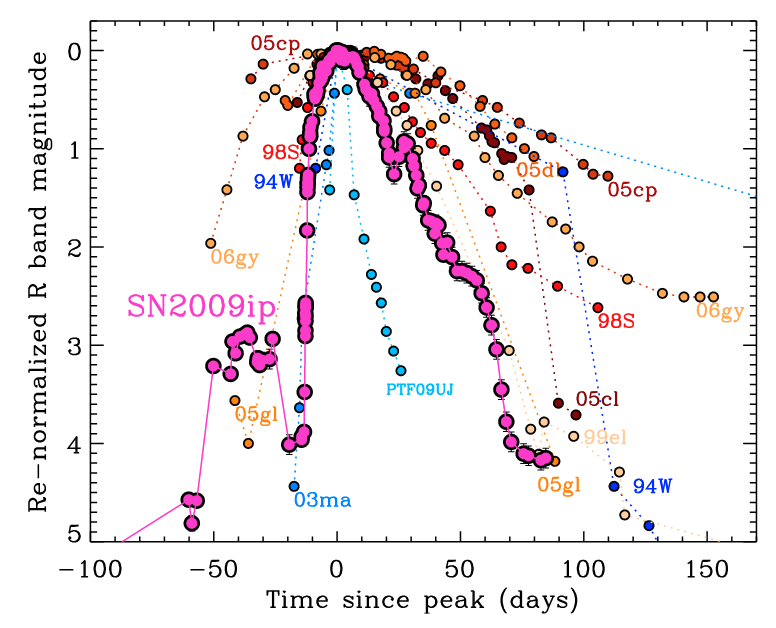 

#### This notebook

This notebook reads alerts from a provided fixed collection of alerts, filters these and performs a lightcurve template match. In particular, it compares whether the lightcurve is better fit by SN2009ip than a normal SNIa (the main assumed false-positive).

This is done fully sequential, in the notebook, without relying on any external database or units.

In [ ]:
%load_ext ampel_quick_import
%qi AmpelLogger SimpleDecentFilterCopy DevAlertProcessor AbsLightCurveT2Unit LightCurve ZTFAlert
from ampel.type import T2UnitResult
import numpy as np
from astropy.table import Table
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", category=DeprecationWarning, module="sncosmo")
    import sncosmo    

### Traversing and filtering a local alert collection

In [ ]:
# Path to an alert archive.
# In principle, the full ZTF alert history can be accessed through https://ztf.uw.edu/alerts/public/
# This repository contains an initial small set of 200 alerts taken from Sep 17 2020.
ALERT_ARCHIVE = '../sample_data/ztfpub_200917_pruned.tar.gz'

In [ ]:
# Every log message is (later) stored in the DB
logger = AmpelLogger.get_logger()

In [ ]:
# As the first step, a basic filter will be applied to the alert stream
# In particular, the search we will do is only meaningful for transients with a certain number
# of detections.
t0filter = SimpleDecentFilterCopy(
        min_rb=0.3,
        min_ndet=7,
        min_tspan=10,
        max_tspan = 200,
        min_gal_lat=15,
        logger=logger
    )

In [ ]:
# This sets up a local alert processor, which can traverse a collection of ZTF alerts.
# AMPEL contains other alert processors, most notable those which accepts a live stream (e.g. Kafka)
ap = DevAlertProcessor( t0filter )

In [ ]:
# Lets now process the first iter_max alerts
iter_max = 1000
n_processed = ap.process_tar( ALERT_ARCHIVE, iter_max=iter_max )

In [ ]:
print('Processed %s alerts out of which %s were accepted'%(n_processed,len(ap.get_accepted_alerts())))

### Comparing the lightcurves

In [ ]:
# First, we define the calculation we wish to apply to the alert content (a photometric LightCurve)
class T2FindSN2009ip(AbsLightCurveT2Unit):
    """
    This module tests whether a state LightCurve is well matched by SN2009ip.
    To be this, it has to:
    - Provide good fit to the data
    - Provide a better fit than a SNIa lightcurve
    Evaluations done using SNCosmo.
    Warning: MW or host galaxy reddening not accounted for!
    
    The run method, applied to a LightCurve, will return a dict (T2UnitResult).
    In this 
       'model_match':True
    for selected objects. 
    (For this sample case we also include the fitted model).
    
    """

    saltmodel = sncosmo.Model(source='salt2')
    sn09ipmodel = sncosmo.Model(source='v19-2009ip-corr')
    
        
    def run(self, light_curve: LightCurve) -> T2UnitResult:
        """
        

        Parameters
        -----------
        light_curve: "ampel.view.LightCurve" instance.
        See the LightCurve docstring for more info.

        Returns
        -------
        dict
        """

        self.logger.info('Fitting %s'%(light_curve.stock_id) )

        # Create SNCosmo input table
        phot = np.asarray( light_curve.get_ntuples(('jd','magpsf','sigmapsf','fid')) )
        phot_tab = Table(phot,names=('jd','magpsf','sigmapsf','fid'))
        phot_tab['band'] = 'ztfband'
        for fid, fname in zip( [1,2,3], ['ztfg','ztfr','ztfi']):
            phot_tab['band'][phot_tab['fid']==fid] = fname
        phot_tab['flux'] = 10 ** (-(phot_tab['magpsf'] - 25) / 2.5)
        phot_tab['fluxerr'] = np.abs(phot_tab['flux'] * (-phot_tab['sigmapsf'] / 2.5 * np.log(10)))
        phot_tab['zp'] = 25
        phot_tab['zpsys'] = 'ab'
        
        # Fit SNIa
        try:
            result, fitted_model = sncosmo.fit_lc(
                phot_tab, self.saltmodel,
                ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
                bounds={'z':(0., 0.2)})  
            chidof_snia = result.chisq / result.ndof
        except RuntimeError:
            # We interpret a poor fit a a weird lightcurve, and exit
            self.logger.info("Salt fit fails",extra={"stock_id":light_curve.stock_id})
            return {'chidof_snia':np.inf,'chidof_09ip':0, 'model_match': False, 'info': 'saltfit fails'}
        
        # Fit Vincenzi et al. 2019 model of SN2009ip
        # SN2009ip-like objects as neutrino sources?
        try:
            result, fitted_model = sncosmo.fit_lc(
                phot_tab, self.sn09ipmodel, vparam_names=['z', 't0', 'amplitude'], bounds={'z':(0,0.2)}  )  
            chidof_09ip = result.chisq / result.ndof
        except RuntimeError:
            # We interpret a poor fit a a weird lightcurve, and exit
            self.logger.info("Model fit fails",extra={"stock_id":light_curve.stock_id})
            return {'chidof_snia':chidof_snia,'chidof_09ip':np.inf, 'model_match': False, 'info': 'saltfit failes'}
        
        # Gather information to propagate / log
        fit_info = {'chidof_snia':chidof_snia,'chidof_09ip':chidof_09ip}

        # Crude decision made
        # Want a reasonable fit
        if chidof_09ip>3:
            fit_info['model_match'] = False
            fit_info['info'] = 'Poor lc match'
        # Do not want the salt model to be "much" better
        elif chidof_snia < ( chidof_09ip * 0.5 ):
            fit_info['model_match'] = False
            fit_info['info'] = 'Better SNIa fit'

        else:
            fit_info['model_match'] = True
            fit_info['info'] = 'Good match'
            fit_info['fit_table'] = phot_tab
            fit_info['fit_model'] = fitted_model
            fit_info['fit_errors'] = result.errors
        
        self.logger.info("",extra={'SN90ip_match':fit_info['model_match']} )

        
        return fit_info

In [ ]:
# Initiate our lightcurve tester
analysis_unit = T2FindSN2009ip(logger=logger)

In [ ]:
# Traverse the accepted alerts and record output
analysis_output = {}
for k, al in enumerate(ap.get_accepted_alerts()):
    lc = ZTFAlert.to_lightcurve(pal=al)
    analysis_output[al.id] = analysis_unit.run(lc)

In [ ]:
for sn, t2dict in analysis_output.items():
    if not t2dict['model_match']: 
        continue
    print(sn)
    _ = sncosmo.plot_lc(t2dict['fit_table'], model=t2dict['fit_model'], errors=t2dict['fit_errors'])

We now have the initial seed for a scientific program. There are obvious _scientific_ improvements that can be made: take reddening into account, more sophisticated model treatment or why not add some sklearn ML test? Most of these can be constructed as straightforward extensions of `T2FindSN2009ip`. 

However, if the goal is to construct a real-time experiment for the Very Rubin Observatory there are also a series of _infrastructure_ questions to answer: How does one apply the test to the full LSST alert stream? How do we guarantee provenance (that we can recover what happened at what time) for the full study? How can the scientific experiment be referenced in a way that it can be recreated in 10 years? 

AMPEL contains tools that can take care of such infrastructure questions, with the goal that scientists can focus on finding, for example, the counterparts to extragalactic neutrinos. The next notebook will describe how the test outlined above can be integrated in a full AMPEL instance. At a computer center this can then be applied either to large archive datasets or to a live alert stream.

In [ ]:
from ampel.contrib.sample.t2.T2SNcosmoComp import T2SNcosmoComp

In [ ]:
t2 = T2SNcosmoComp(target_model_name='v19-2009ip-corr', base_model_name='salt2', chi2dof_cut=2, 
                   chicomp_scaling=0.5, logger=logger)

In [ ]:
# Traverse the accepted alerts and record output (as above)
t2_output = {}
for k, al in enumerate(ap.get_accepted_alerts()):
    lc = ZTFAlert.to_lightcurve(pal=al)
    t2_output[al.id] = t2.run(lc)

In [ ]:
t2_output['ZTF20abyfpze']